In [1]:
import stdpopsim
import matplotlib.pyplot as plt
import numpy as np
import tskit
import importlib
import ld_calculator

importlib.reload(ld_calculator)

/nfs_home/users/osvk/.conda/envs/msprime-tskit-env/lib/python3.11/site-packages/stdpopsim/catalog/HomSap/demographic_models.py:158: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.head(1) - 1), rate=0
/nfs_home/users/osvk/.conda/envs/msprime-tskit-env/lib/python3.11/site-packages/stdpopsim/catalog/HomSap/demographic_models.py:161: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.tail(1) + 1), rate=0


<module 'ld_calculator' from '/nfs_home/users/osvk/projects/tskit-ld/ld_calculator.py'>

First, we simulate trees for 80,000 samples using an Out of Africa model. To do this we use stdpopsim, specifying the OutOfAfrica_2T12 two-population model and ask for 40,000 sample nodes each from YRI and EUR populations. The trees are saved to file (ts_OutOfAfrica_2T12_80k.trees), so for future runs we simply load the .trees file.

In [2]:
num_samples = 40_000
""" species = stdpopsim.get_species("HomSap")
contig = species.get_contig("chr22")
model = species.get_demographic_model("OutOfAfrica_2T12")
samples = model.get_samples(num_samples, num_samples)
engine = stdpopsim.get_default_engine()
ts = engine.simulate(model, contig, samples)
print(
    "simulated {} trees and {} sites, from {} samples.".format(
        ts.num_trees, ts.num_sites, ts.num_samples
    )
) 
# ts.dump("ts_OutOfAfrica_2T12_80k.trees")"""

' species = stdpopsim.get_species("HomSap")\ncontig = species.get_contig("chr22")\nmodel = species.get_demographic_model("OutOfAfrica_2T12")\nsamples = model.get_samples(num_samples, num_samples)\nengine = stdpopsim.get_default_engine()\nts = engine.simulate(model, contig, samples)\nprint(\n    "simulated {} trees and {} sites, from {} samples.".format(\n        ts.num_trees, ts.num_sites, ts.num_samples\n    )\n) \n# ts.dump("ts_OutOfAfrica_2T12_80k.trees")'

In [3]:
ts = tskit.load("ts_OutOfAfrica_2T12_80k.trees")
ts

We split the tree sequence into ancestry-specific trees so we can look at within-cohort calculation times.

In [4]:
YRI_samples = ts.samples(0)
EUR_samples = ts.samples(1)
ts_YRI = ts.simplify(samples=YRI_samples)
ts_EUR = ts.simplify(samples=EUR_samples)

In [5]:
# select 20_000 random samples from each population
#samples_subset = np.random.choice(YRI_samples, int(num_samples / 2), replace=False)
#samples_subset = np.append(
#    samples_subset, np.random.choice(EUR_samples, int(num_samples / 2), replace=False)
#)
#ts_sub = ts.simplify(samples=samples_subset)
#ts_sub

ld_calculator.py defines some methods to query pairwise-LD using the r2 method in tskit's LD calculator class. We use these to calculate the LD between 500 randomly selected variant pairs located within 200 kb of each other. We keep track of the cpu time taken for each query and the distance between variants in each pair.

In [6]:
def calc_ld_by_pop(ts, chr, num_sites, max_dist):
    ld_calc = ld_calculator.LdInfo(ts, chr)
    sites_a = np.sort(
        np.random.choice(ld_calc.get_single_mutation_sites(), size=num_sites)
    )
    sites_b = ld_calc.return_random_sites_in_range(sites_a, max_dist=max_dist)
    r2, compute_times = ld_calc.compute_ld_with_time(sites_a, sites_b)
    distances = ld_calc.compute_distance_between_sites(sites_a, sites_b)
    distances = np.array(distances) / 1_000
    return r2, distances, compute_times

In [7]:
# sample 500 sites from the full and population-specific trees
num_sites = 500
max_dist = 200_000
chr = 22
EUR_r2, EUR_distances, EUR_compute_times = calc_ld_by_pop(
    ts_EUR, chr, num_sites, max_dist
)
YRI_r2, YRI_distances, YRI_compute_times = calc_ld_by_pop(
    ts_YRI, chr, num_sites, max_dist
)
#EUR_YRI_r2, EUR_YRI_distances, EUR_YRI_compute_times = calc_ld_by_pop(
#    ts_sub, chr, num_sites, max_dist
#)

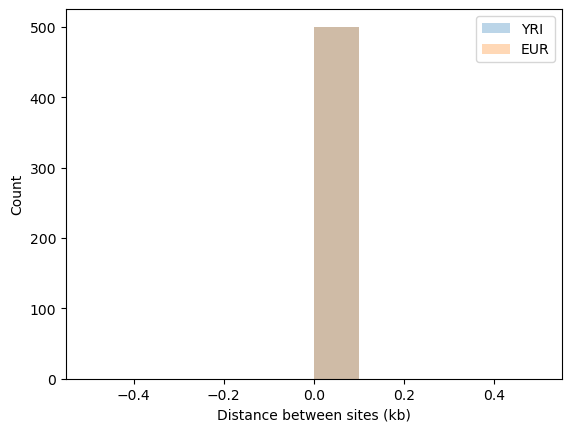

In [10]:
# distribution of distances
plt.hist(YRI_distances, alpha=0.3, label="YRI")
plt.hist(EUR_distances, alpha=0.3, label="EUR")
#plt.hist(EUR_YRI_distances, alpha=0.3, label="YRI + EUR")
plt.xlabel("Distance between sites (kb)")
plt.ylabel("Count")
plt.legend()
plt.show()

We can then plot the time taken for a query as a function of the distance between the queried variants. We expect a linear relationship, with far-away variants requiring more time. We calculate Pearson's correlation coefficient within ancestries and overall, and draw lines of best fit.

/nfs_home/users/osvk/.conda/envs/msprime-tskit-env/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/nfs_home/users/osvk/.conda/envs/msprime-tskit-env/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


NameError: name 'EUR_YRI_distances' is not defined

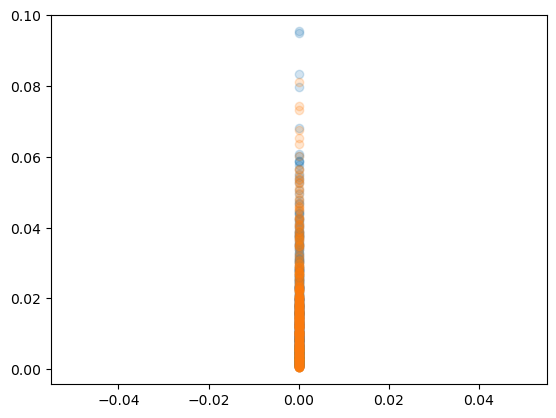

In [9]:
# dist v time
plt.scatter(YRI_distances, YRI_compute_times, alpha=0.2, label="YRI")
plt.scatter(EUR_distances, EUR_compute_times, alpha=0.2, label="EUR")
#plt.scatter(EUR_YRI_distances, EUR_YRI_compute_times, alpha=0.2, label="YRI + EUR")

corr_YRI = f"YRI (corr = {np.corrcoef(YRI_distances, YRI_compute_times)[0,1]:.2f})"
corr_EUR = f"EUR (corr = {np.corrcoef(EUR_distances, EUR_compute_times)[0,1]:.2f})"
corr_EUR_YRI = f"YRI + EUR  (corr = {np.corrcoef(EUR_YRI_distances, EUR_YRI_compute_times)[0,1]:.2f})"
plt.plot(
    np.unique(YRI_distances),
    np.poly1d(np.polyfit(YRI_distances, YRI_compute_times, 1))(
        np.unique(YRI_distances)
    ),
    label=f"{corr_YRI}",
    linewidth=2,
    alpha=0.5,
)
plt.plot(
    np.unique(EUR_distances),
    np.poly1d(np.polyfit(EUR_distances, EUR_compute_times, 1))(
        np.unique(EUR_distances)
    ),
    label=f"{corr_EUR}",
    linewidth=2,
    alpha=0.5,
)
#plt.plot(
#    np.unique(EUR_YRI_distances),
#    np.poly1d(np.polyfit(EUR_YRI_distances, EUR_YRI_compute_times, 1))(
#        np.unique(EUR_YRI_distances)
#    ),
#    label=f"{corr_EUR_YRI}",
#    linewidth=2,
#    alpha=0.5,
#)
plt.title(
    f"Time taken vs distance within populations\n({num_sites:,} variant pairs, {num_samples:,} samples)"
)
plt.xlabel("Distance between sites (kb)")
plt.ylabel("Time taken (s)")
plt.legend()
plt.show()

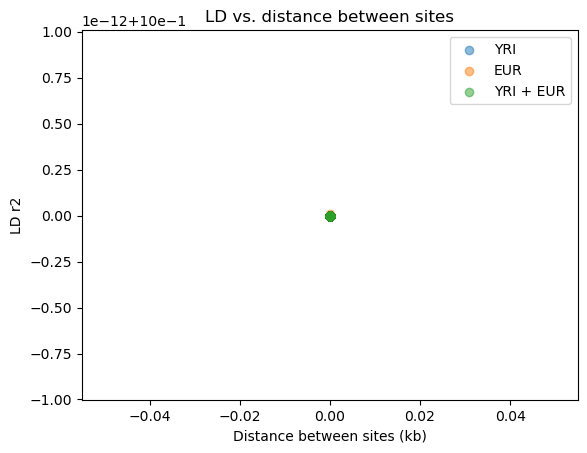

In [ ]:
# r2 v distance
plt.scatter(YRI_distances, YRI_r2, alpha=0.5, label="YRI")
plt.scatter(EUR_distances, EUR_r2, alpha=0.5, label="EUR")
#plt.scatter(EUR_YRI_distances, EUR_YRI_r2, alpha=0.5, label="YRI + EUR")
plt.xlabel("Distance between sites (kb)")
plt.ylabel("LD r2")
plt.title("LD vs. distance between sites")
plt.legend()
plt.show()